In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# Load the data

In [2]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)
w = np.array([1, 2])
e = y - tx @ w
print(e)
print(y.shape, tx.shape, np.transpose(w).shape)


[104.9315547   71.43388117  91.55946151 ...  58.62717056  72.00276808
  52.89610924]
(10000,) (10000, 2) (2,)


In [3]:
y.shape, tx.shape[1],np.transpose(w).shape

((10000,), 2, (2,))

### NB: throughout this laboratory the data has the following format: 
  * there are **N = 10000** data entries
  * **y** represents the column vector containing weight information -- that which we wish to predict/the output (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,)**.
  * **tx** represents the matrix $\tilde{X}$ formed by laterally concatenating a column vector of 1s to the column vector of height information -- the input data (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,2)**.

# 1. Computing the Cost Function
Fill in the `compute_loss` function below:

In [4]:
def compute_loss(y, tx, w):
    """Calculate the loss using either MSE or MAE.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2,). The vector of model parameters.

    Returns:
        the value of the loss (a scalar), corresponding to the input parameters w.
    """
    # ***************************************************
    # compute loss by MSE
    # ***************************************************
    N = y.shape[0]
    e = y - tx @ w
    return 1/(2*N) * e @ e 

# 2. Grid Search

Fill in the function `grid_search()` below:

In [5]:
# from costs import *


def grid_search(y, tx, grid_w0, grid_w1):
    """Algorithm for grid search.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        grid_w0: numpy array of shape=(num_grid_pts_w0, ). A 1D array containing num_grid_pts_w0 values of parameter w0 to be tested in the grid search.
        grid_w1: numpy array of shape=(num_grid_pts_w1, ). A 1D array containing num_grid_pts_w1 values of parameter w1 to be tested in the grid search.

    Returns:
        losses: numpy array of shape=(num_grid_pts_w0, num_grid_pts_w1). A 2D array containing the loss value for each combination of w0 and w1
    """
    losses = np.zeros((len(grid_w0), len(grid_w1)))

    for i in range(len(grid_w0)):
        for j in range(len(grid_w1)):
            w0 = grid_w0[i]
            w1 = grid_w1[j]
            w = np.array([w0, w1])
            losses[i,j] = compute_loss(y, tx, w)
        
    
    return losses

Let us play with the grid search demo now!

Grid Search: loss*=18.79354101952324, w0*=71.42857142857142, w1*=15.306122448979579, execution time=0.061 seconds


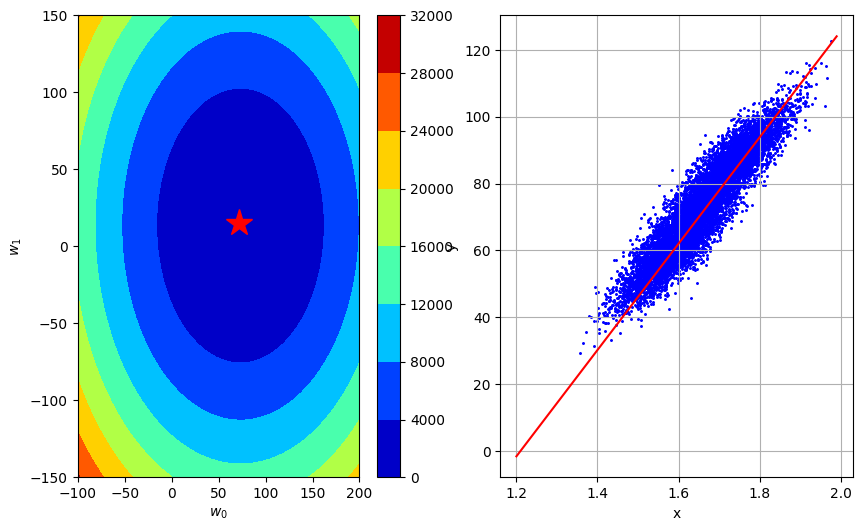

In [6]:
from grid_search import generate_w, get_best_parameters
from plots import grid_visualization

# Generate the grid of parameters to be swept
grid_w0, grid_w1 = generate_w(num_intervals=50)

# Start the grid search
start_time = datetime.datetime.now()
grid_losses = grid_search(y, tx, grid_w0, grid_w1)

# Select the best combinaison
loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
end_time = datetime.datetime.now()
execution_time = (end_time - start_time).total_seconds()

# Print the results
print(
    "Grid Search: loss*={l}, w0*={w0}, w1*={w1}, execution time={t:.3f} seconds".format(
        l=loss_star, w0=w0_star, w1=w1_star, t=execution_time
    )
)

# Plot the results
fig = grid_visualization(grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight)
fig.set_size_inches(10.0, 6.0)
fig.savefig("grid_plot")  # Optional saving

# 3. Gradient Descent

Again, please fill in the functions `compute_gradient` below:

In [7]:
def compute_gradient(y, tx, w):
    """Computes the gradient at w.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        An numpy array of shape (2, ) (same shape as w), containing the gradient of the loss at w.
    """
    # ***************************************************
    # compute gradient vector
    # ***************************************************
    N = y.shape[0]
    e = y - tx @ w
    return -1/N * np.transpose(tx) @ e

Please fill in the functions `gradient_descent` below:

In [8]:
def gradient_descent(y, tx, initial_w, max_iters, gamma):
    """The Gradient Descent (GD) algorithm.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of GD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of GD
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = np.zeros(max_iters)
    w = initial_w
    for n_iter in range(max_iters):
        # ***************************************************
        # compute gradient and loss
        # ***************************************************
        g = compute_gradient(y,tx,w)
        loss = compute_loss(y,tx,w)
        # ***************************************************
        # update w by gradient
        # ***************************************************
        w = w - gamma*g

        # store w and loss
        ws.append(w)
        losses[n_iter] = loss
        print(
            "GD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )

    return losses, ws

Test your gradient descent function through gradient descent demo shown below:

In [9]:
# from gradient_descent import *
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.1

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()
gd_losses, gd_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

GD iter. 0/49: loss=2792.236712759167, w0=7.329392200210518, w1=1.3479712434989066
GD iter. 1/49: loss=2264.6350560300034, w0=13.925845180400005, w1=2.561145362647923
GD iter. 2/49: loss=1837.2777140793787, w0=19.86265286257052, w1=3.65300206988203
GD iter. 3/49: loss=1491.1182670993746, w0=25.20577977652398, w1=4.635673106392729
GD iter. 4/49: loss=1210.7291150455717, w0=30.014593999082106, w1=5.520077039252352
GD iter. 5/49: loss=983.6139018819904, w0=34.342526799384416, w1=6.316040578826015
GD iter. 6/49: loss=799.6505792194895, w0=38.23766631965648, w1=7.032407764442318
GD iter. 7/49: loss=650.6402878628645, w0=41.74329188790136, w1=7.677138231496992
GD iter. 8/49: loss=529.9419518639978, w0=44.898354899321745, w1=8.257395651846194
GD iter. 9/49: loss=432.17629970491566, w0=47.73791160960009, w1=8.779627330160476
GD iter. 10/49: loss=352.9861214560594, w0=50.29351264885061, w1=9.249635840643334
GD iter. 11/49: loss=288.8420770744854, w0=52.593553584176064, w1=9.6726435000779
GD ite

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

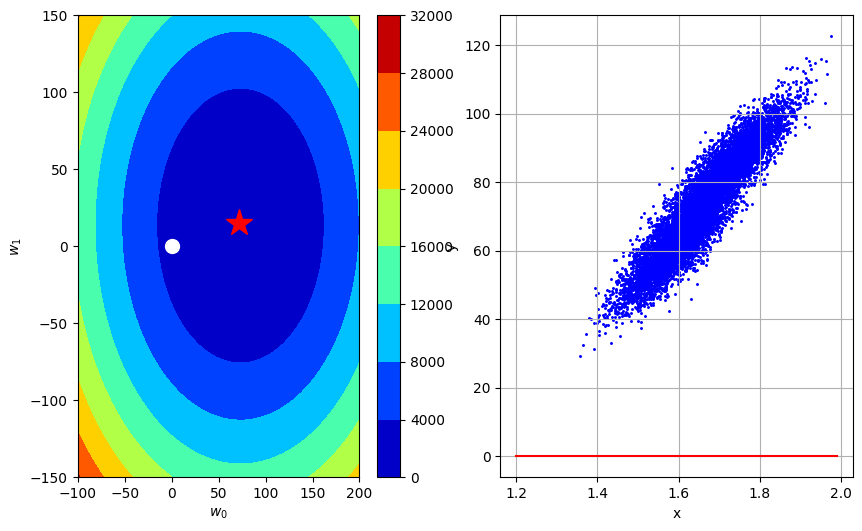

In [10]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses,
        gd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

# 4. Stochastic gradient descent

In [11]:
def compute_stoch_gradient(y, tx, w):
    """Compute a stochastic gradient at w from a data sample batch of size B, where B < N, and their corresponding labels.

    Args:
        y: numpy array of shape=(B, )
        tx: numpy array of shape=(B,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the stochastic gradient of the loss at w.
    """

    # ***************************************************
    # implement stochastic gradient computation. It's the same as the usual gradient.
    # ***************************************************
    N = y.shape[0]
    e = y - tx @ np.transpose(w)
    return -1/N * np.dot(np.transpose(tx),e)


def stochastic_gradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """The Stochastic Gradient Descent algorithm (SGD).

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic gradient
        max_iters: a scalar denoting the total number of iterations of SGD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SGD
    """

    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w

    for n_iter in range(max_iters):
        # ***************************************************
        # implement stochastic gradient descent.
        # ***************************************************
        # store the loss and gradients of each minibatch
        b_losses = []
        b_gradients = []
        for minibatch_y, minibatch_tx in batch_iter(y, tx, batch_size):
            g = compute_gradient(minibatch_y, minibatch_tx, w)
            loss = compute_loss(minibatch_y, minibatch_tx, w)
            b_gradients.append(g)
            b_losses.append(loss)

        # Compute the sum of the loss and the gradients of each minibatch
        loss = sum(b_losses)/len(b_losses)
        g = sum(b_gradients)/len(b_losses)

        # Update w
        w = w - gamma*g

        ws.append(w)
        losses.append(loss)
        
        print(
            "SGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )
    return losses, ws

In [12]:
# from stochastic_gradient_descent import *

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.1
batch_size = 5

# Initialization
w_initial = np.array([0, 0])

# Start SGD.
start_time = datetime.datetime.now()
sgd_losses, sgd_ws = stochastic_gradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma
)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD iter. 0/49: loss=1642.5799610395047, w0=5.709362281466106, w1=-5.576401633223629
SGD iter. 1/49: loss=1630.2636443638096, w0=11.361010659949837, w1=-7.8168783379898645
SGD iter. 2/49: loss=2981.4665991324428, w0=19.045038485763826, w1=-3.0558533658435527
SGD iter. 3/49: loss=2226.1684391982294, w0=25.65627742599156, w1=2.127320510976653
SGD iter. 4/49: loss=1683.4170493921317, w0=31.4269584552206, w1=8.36184998098759
SGD iter. 5/49: loss=573.8314395094109, w0=34.79774456947561, w1=5.9677904317096875
SGD iter. 6/49: loss=1028.6813368214396, w0=39.32272697011822, w1=8.581915891989325
SGD iter. 7/49: loss=683.2453998192673, w0=43.009826162623206, w1=9.61701808404856
SGD iter. 8/49: loss=307.06287050498247, w0=45.476808639290184, w1=7.249788287900362
SGD iter. 9/49: loss=742.7787904506239, w0=49.30711345643695, w1=11.333595071378998
SGD iter. 10/49: loss=261.5221549025483, w0=51.54465672799741, w1=9.250711908980984
SGD iter. 11/49: loss=459.50670477847353, w0=54.51344050263417, w1=12.0

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

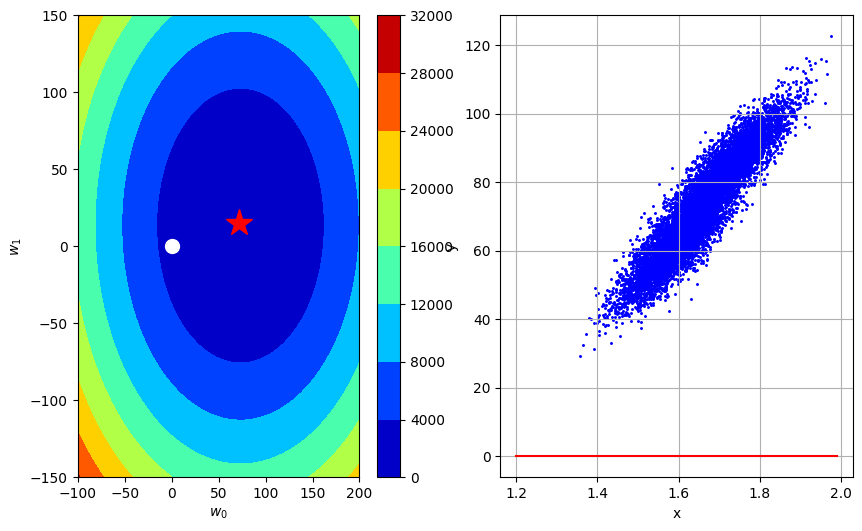

In [13]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sgd_losses,
        sgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(sgd_ws)))

# 5. Effect of Outliers and MAE Cost Function

In [14]:
import datetime
from helpers import *

# ***************************************************
# INSERT YOUR CODE HERE
# TODO: reload the data by subsampling first, then by subsampling and adding outliers
# ***************************************************
height, weight, gender = load_data(sub_sample=True, add_outlier=True)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [15]:
y.shape, tx.shape

((204,), (204, 2))

In [16]:
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7
#batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()

# ***************************************************
# INSERT YOUR CODE HERE
# fit the model to the subsampled data / subsampled data with outliers and visualize the cloud of points
#       and the model fit
# ***************************************************

gd_losses, gd_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
"""
sgd_losses, sgd_ws = stochastic_gradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma
)
"""

end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

GD iter. 0/49: loss=2928.547820456083, w0=52.25217281614962, w1=8.118019470746582
GD iter. 1/49: loss=332.08400232962725, w0=67.92782466099447, w1=10.553425311970448
GD iter. 2/49: loss=98.4022586982475, w0=72.63052021444793, w1=11.284047064337575
GD iter. 3/49: loss=77.37090177142338, w0=74.04132888048396, w1=11.503233590047705
GD iter. 4/49: loss=75.47807964800923, w0=74.46457148029477, w1=11.56898954776074
GD iter. 5/49: loss=75.30772565690198, w0=74.59154426023801, w1=11.58871633507465
GD iter. 6/49: loss=75.2923937977023, w0=74.62963609422098, w1=11.594634371268821
GD iter. 7/49: loss=75.29101393037436, w0=74.64106364441588, w1=11.596409782127074
GD iter. 8/49: loss=75.29088974231483, w0=74.64449190947434, w1=11.59694240538455
GD iter. 9/49: loss=75.29087856538949, w0=74.64552038899188, w1=11.597102192361794
GD iter. 10/49: loss=75.29087755946618, w0=74.64582893284715, w1=11.597150128454967
GD iter. 11/49: loss=75.29087746893309, w0=74.64592149600372, w1=11.59716450928292
GD iter.

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

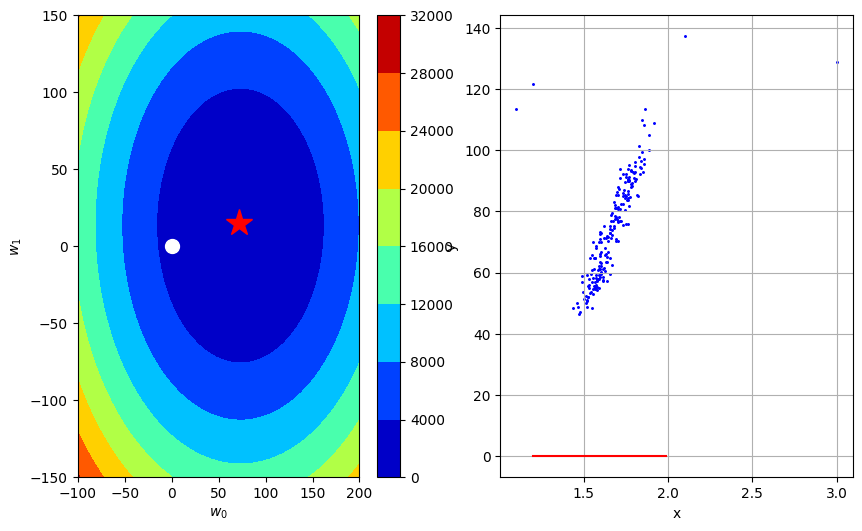

In [17]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses,
        gd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

# 6. Subgradient descent

In [18]:
def compute_subgradient_mae(y, tx, w):
    """Compute a subgradient of the MAE at w.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the subgradient of the MAE at w.
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # compute subgradient gradient vector for MAE
    # ***************************************************
    return -1/y.shape[0] * np.transpose(tx) @ np.sign(y - tx @ w)

In [19]:
def subgradient_descent(y, tx, initial_w, max_iters, gamma):
    """The SubGradient Descent (SubGD) algorithm.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubGD
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # compute subgradient and loss
        g = compute_subgradient_mae(y,tx,w)
        loss = compute_loss(y,tx,w)
        
        # update w by subgradient
        w = w - gamma*g

        ws.append(w)
        losses.append(loss)
        print(
            "SubGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )

    return losses, ws

In [20]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subgd_losses, subgd_ws = subgradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubGD: execution time={t:.3f} seconds".format(t=exection_time))

SubGD iter. 0/499: loss=2928.547820456083, w0=0.699999999999999, w1=2.0691781621451354e-15
SubGD iter. 1/499: loss=2876.5406476399326, w0=1.399999999999998, w1=4.138356324290271e-15
SubGD iter. 2/499: loss=2825.0234748237835, w0=2.099999999999997, w1=6.207534486435406e-15
SubGD iter. 3/499: loss=2773.9963020076334, w0=2.799999999999996, w1=8.276712648580542e-15
SubGD iter. 4/499: loss=2723.459129191485, w0=3.4999999999999947, w1=1.0345890810725678e-14
SubGD iter. 5/499: loss=2673.4119563753356, w0=4.199999999999994, w1=1.2415068972870813e-14
SubGD iter. 6/499: loss=2623.854783559186, w0=4.899999999999993, w1=1.448424713501595e-14
SubGD iter. 7/499: loss=2574.7876107430357, w0=5.5999999999999925, w1=1.6553425297161083e-14
SubGD iter. 8/499: loss=2526.2104379268867, w0=6.299999999999992, w1=1.8622603459306218e-14
SubGD iter. 9/499: loss=2478.123265110737, w0=6.999999999999991, w1=2.0691781621451352e-14
SubGD iter. 10/499: loss=2430.526092294588, w0=7.69999999999999, w1=2.2760959783596486

interactive(children=(IntSlider(value=1, description='n_iter', max=501, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>

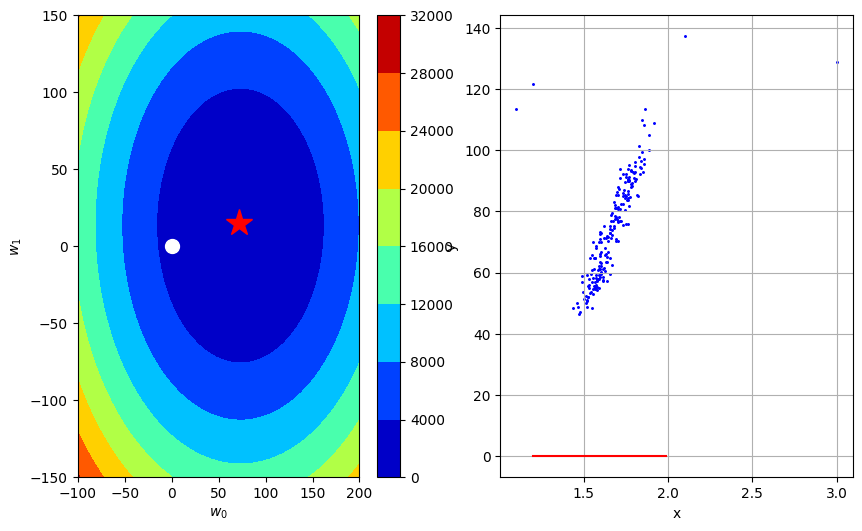

In [21]:
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subgd_losses,
        subgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(subgd_ws)))

# Stochastic Subgradient Descent

**NB** for the computation of the subgradient you can reuse the `compute_subgradient` method that you implemented above, just making sure that you pass in a minibatch as opposed to the full data.

In [22]:
def stochastic_subgradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """Compute a stochastic subgradient at w from a data sample batch of size B, where B < N, and their corresponding labels.

    Args:
        y: numpy array of shape=(B, )
        tx: numpy array of shape=(B,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic subgradient
        max_iters: a scalar denoting the total number of iterations of SubSGD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubSGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubSGD
    """

    # Define parameters to store w and loss
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w

    for n_iter in range(max_iters):
        # ***************************************************
        # implement stochastic gradient descent.
        # ***************************************************
        # store the loss and gradients of each minibatch
        b_losses = []
        b_gradients = []
        for minibatch_y, minibatch_tx in batch_iter(y, tx, batch_size):
            g = compute_subgradient_mae(minibatch_y, minibatch_tx, w)
            loss = compute_loss(minibatch_y, minibatch_tx, w)
            b_gradients.append(g)
            b_losses.append(loss)

        # Compute the sum of the loss and the gradients of each minibatch
        loss = sum(b_losses)/len(b_losses)
        g = sum(b_gradients)/len(b_losses)

        # Update w
        w = w - gamma*g

        ws.append(w)
        losses.append(loss)

        print(
            "SubSGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )
    return losses, ws

In [23]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subsgd_losses, subsgd_ws = stochastic_subgradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma
)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubSGD: execution time={t:.3f} seconds".format(t=exection_time))

SubSGD iter. 0/499: loss=1186.11726614271, w0=0.7, w1=-0.6799094823218823
SubSGD iter. 1/499: loss=2110.8814009670928, w0=1.4, w1=-0.8737661226574954
SubSGD iter. 2/499: loss=4290.794310310601, w0=2.0999999999999996, w1=-0.6504826585720596
SubSGD iter. 3/499: loss=3205.944629958386, w0=2.8, w1=-0.18794481795588952
SubSGD iter. 4/499: loss=3865.0808948140934, w0=3.5, w1=0.24881367097135426
SubSGD iter. 5/499: loss=2226.187606380957, w0=4.2, w1=-0.26514977534368595
SubSGD iter. 6/499: loss=3701.928547105764, w0=4.9, w1=0.16617568421187845
SubSGD iter. 7/499: loss=1386.15657215245, w0=5.6000000000000005, w1=-0.09227355861392816
SubSGD iter. 8/499: loss=1048.1925957286633, w0=6.300000000000001, w1=-0.8544053347859596
SubSGD iter. 9/499: loss=1463.2433319567701, w0=7.000000000000001, w1=-1.231071463921066
SubSGD iter. 10/499: loss=3599.990211501311, w0=7.700000000000001, w1=-0.6277515442155128
SubSGD iter. 11/499: loss=750.0720160613758, w0=8.4, w1=-1.501807066196021
SubSGD iter. 12/499: lo

interactive(children=(IntSlider(value=1, description='n_iter', max=501, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>

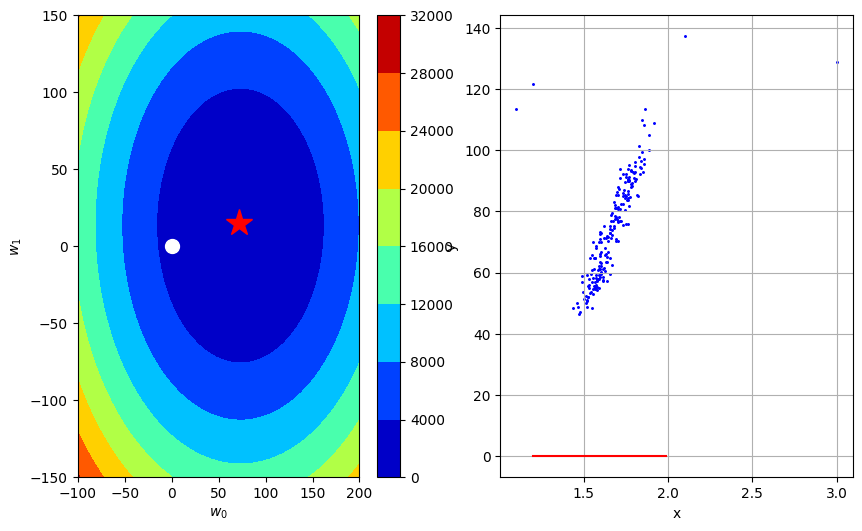

In [24]:
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subsgd_losses,
        subsgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(subsgd_ws)))